In [32]:
include("../src/Graph.jl")
include("../src/DataModule.jl")
include("../src/UtilsModule.jl")
include("../src/AccuracyModule.jl")
include("../src/GradientOptimizersModule.jl")

In [38]:
using .DataModule, .UtilsModule, .AccuracyModule
using Random, Plots

In [39]:
function load_data(batch_size)
    println("Loading train data...")
    train_x, train_y = DataModule.preprocess(:train; one_hot = true)

    train_x_batched = DataModule.batch(train_x, batch_size)
    train_y_batched = DataModule.batch(train_y, batch_size)

    println("Loading test data...")
    test_x, test_y = DataModule.preprocess(:test; one_hot = true)
    return train_x, train_y, train_x_batched, train_y_batched, test_x, test_y
end

load_data (generic function with 1 method)

In [40]:
function update_weights!(graph::Vector, optimizer::GradientOptimizersModule.GradientOptimizer)
    for node in graph
        if isa(node, Variable)
            if node.gradient != nothing
                node.output .-= optimizer(node.gradient)
                node.gradient .= 0
            end
        end
    end
end

update_weights! (generic function with 5 methods)

In [45]:
batch_loss = Float64[]
batch_acc = Float64[]

Float64[]

In [46]:
function main(batch_size::Int, epochs::Int, optimizer::GradientOptimizersModule.GradientOptimizer)
    train_x, train_y, train_x_batched, train_y_batched, test_x, test_y = load_data(batch_size)

    x1 = Variable(zeros(Float32, 1, 1))
    x2 = Variable(zeros(Float32, 1, 1))
    x3 = Variable(zeros(Float32, 1, 1))
    x4 = Variable(zeros(Float32, 1, 1))

    wd = Variable(UtilsModule.glorot_uniform(10, 64))
    bd = Variable(UtilsModule.glorot_uniform(10, ))
    fd = Constant(UtilsModule.identity)
    dfd = Constant(UtilsModule.identity_deriv)

    wr = Variable(UtilsModule.glorot_uniform(64, 196))
    hwr = Variable(UtilsModule.glorot_uniform(64, 64))
    br = Variable(UtilsModule.glorot_uniform(64, ))
    fr = Constant(tanh)
    dfr = Constant(UtilsModule.tanh_deriv)

    state0_value = zeros(Float32, 64, 100)
    state0 = Variable(state0_value)

    r1 = rnn_layer(wr, hwr, state0, br, x1, fr, dfr)
    r2 = rnn_layer(wr, hwr, r1, br, x2, fr, dfr)
    r3 = rnn_layer(wr, hwr, r2, br, x3, fr, dfr)
    r4 = rnn_layer(wr, hwr, r3, br, x4, fr, dfr)
    d = dense_layer(r4, wd, bd, fd, dfd)
    graph = topological_sort(d)
    
    println("Training")
    for epoch in 1:epochs
        batches = randperm(size(train_x_batched, 1))
        @time for batch in batches
            state0.output = state0_value
            x1.output = train_x_batched[batch][  1:196,:]
            x2.output = train_x_batched[batch][197:392,:]
            x3.output = train_x_batched[batch][393:588,:]
            x4.output = train_x_batched[batch][589:end,:]
            result = forward!(graph)

            loss = AccuracyModule.loss(result, train_y_batched[batch])
            acc = AccuracyModule.accuracy(result, train_y_batched[batch])
            push!(batch_loss, loss)
            push!(batch_acc, acc)
            gradient = AccuracyModule.gradient(result, train_y_batched[batch]) ./ batch_size
            backward!(graph, seed=gradient)
            update_weights!(graph, optimizer)
        end
        state0.output = zeros(64, 10000)
        test_graph = topological_sort(d)

        x1.output = test_x[  1:196,:]
        x2.output = test_x[197:392,:]
        x3.output = test_x[393:588,:]
        x4.output = test_x[589:end,:]
        result = forward!(test_graph)

        loss = AccuracyModule.loss(result, test_y)
        acc = AccuracyModule.accuracy(result, test_y)

        @show epoch loss acc
    end
end

main (generic function with 2 methods)

In [47]:
main(100, 5, GradientOptimizersModule.Descent(15e-3))

Loading train data...
Loading test data...
Training
  2.035350 seconds (258.01 k allocations: 906.497 MiB, 10.03% gc time)
epoch = 1
loss = 0.52711356f0
acc = 86.73
  1.968746 seconds (258.00 k allocations: 906.510 MiB, 7.81% gc time)
epoch = 2
loss = 0.38665795f0
acc = 89.77
  1.794815 seconds (258.00 k allocations: 906.482 MiB, 2.42% gc time)
epoch = 3
loss = 0.3282022f0
acc = 91.01
  1.805855 seconds (258.00 k allocations: 906.545 MiB, 2.52% gc time)
epoch = 4
loss = 0.29427728f0
acc = 91.63
  1.810055 seconds (258.00 k allocations: 906.482 MiB, 2.49% gc time)
epoch = 5
loss = 0.2701523f0
acc = 92.38


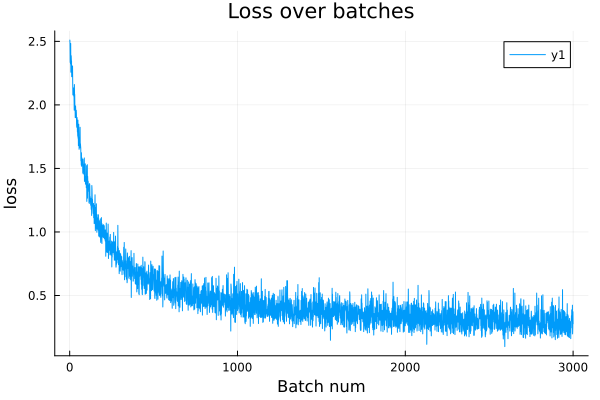

In [48]:
plot(batch_loss, xlabel="Batch num", ylabel="loss", title="Loss over batches")

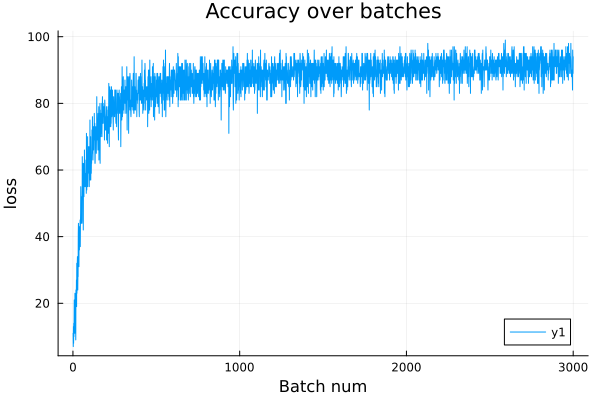

In [49]:
plot(batch_acc, xlabel="Batch num", ylabel="loss", title="Accuracy over batches")